<a href="https://colab.research.google.com/github/vitroid/PairList/blob/master/benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
try:
    import google.colab
    ! pip install pairlist
    ! git clone https://github.com/vitroid/PairList.git
    import sys
    sys.path.append("PairList")
except:
    ! pip install .

fatal: destination path 'PairList' already exists and is not an empty directory.


In [7]:
import pairlist as pl
from benchmark.fcc import FaceCenteredCubic
from logging import getLogger, basicConfig, INFO, DEBUG
from benchmark.decorator import timeit, banner
import numpy as np
from pairlist import pairs_py, pairs2_py


basicConfig(level=INFO, format="%(levelname)s %(message)s")
logger = getLogger()
logger.setLevel(INFO)
logger.debug("Debug mode.")


@banner
@timeit
def crude(lattice, cell, rc=1.1):
    "Neighboring pair list by a crude double loop."
    rc2 = rc**2
    count = 0
    for i in range(len(lattice)):
        for j in range(i):
            d = lattice[i] - lattice[j]
            d -= np.floor(d + 0.5)
            d = d @ cell
            if d @ d < rc2:
                count += 1
    return count


@banner
@timeit
def numpyish(lattice, cell, rc=1.1):
    "Neighboring pair list by numpy fancy array."
    # cross-differences
    M = lattice[:, None, :] - lattice[None, :, :]
    # wrap
    M -= np.floor(M + 0.5)
    # in absolute coordinate
    M = M @ cell
    d = (M * M).sum(2)
    return d[(d < rc**2) & (0 < d)].shape[0] / 2


@banner
@timeit
def pairlist_py(lattice, cell, rc=1.1):
    "Neighboring pair list by pairlist in pure python."
    count = 0
    for i, j, d in pl.pairs_iter(
        lattice, maxdist=rc, cell=cell, _engine=(pairs_py, pairs2_py)
    ):
        count += 1
    return count


@timeit
@banner
def pairlist_c(lattice, cell, rc=1.1):
    "Neighboring pair list by pairlist in c."
    count = 0
    for i, j, d in pl.pairs_iter(lattice, maxdist=rc, cell=cell):
        count += 1
    return count


lattice, cell = FaceCenteredCubic(10)

print(crude(lattice, cell), "pairs")
print(numpyish(lattice, cell), "pairs")
print(pairlist_py(lattice, cell), "pairs")
print(pairlist_c(lattice, cell), "pairs")


INFO:root:crude: Neighboring pair list by a crude double loop.
INFO:root:crude: 60742 ms
INFO:root:crude: end.
INFO:root:numpyish: Neighboring pair list by numpy fancy array.


24000 pairs


INFO:root:numpyish: 1563 ms
INFO:root:numpyish: end.
INFO:root:pairlist_py: Neighboring pair list by pairlist in pure python.


24000.0 pairs


INFO:root:pairlist_py: 440 ms
INFO:root:pairlist_py: end.
INFO:root:pairlist_c: Neighboring pair list by pairlist in c.
INFO:root:pairlist_c: end.
INFO:root:pairlist_c: 32 ms


24000 pairs
24000 pairs


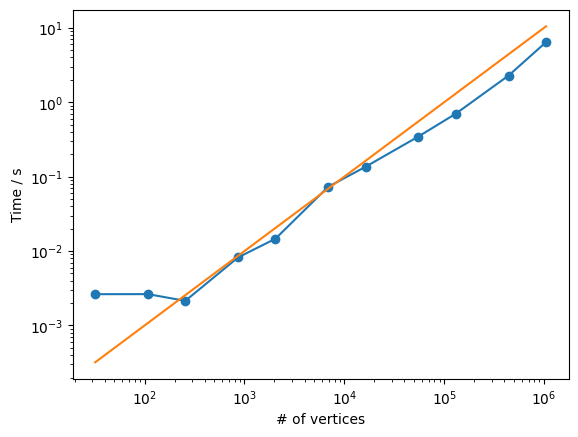

In [8]:
import pairlist as pl
from benchmark.fcc import FaceCenteredCubic
import time
import matplotlib.pyplot as plt
import numpy as np


def pairlist_c(lattice, cell, rc=1.1):
    "Neighboring pair list by pairlist in c."
    count = 0
    for i, j, d in pl.pairs_iter(lattice, maxdist=rc, cell=cell):
        count += 1
    return count


nvertex = []
durations = []
for i in (2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64):
    lattice, cell = FaceCenteredCubic(i)
    nvertex.append(len(lattice))
    start = time.time()
    pairlist_c(lattice, cell)
    duration = time.time() - start
    durations.append(duration)

nvertex = np.array(nvertex, dtype=float)
plt.loglog(nvertex, durations, "o-")
plt.loglog(nvertex, nvertex / 100000, "-")
plt.xlabel("# of vertices")
plt.ylabel("Time / s")

plt.show()
